# GPU Check

In [2]:
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
#from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import numpy as np
import os
from loss_functions.triplet_loss import TripletLoss
import math
import glob
from os import listdir
from os import walk
import PIL.Image as Image
from matplotlib import pyplot as plt

In [3]:
DATA_PATH_TRAIN = '../../dataset/face_labeled_data/train'
DATA_PATH_VAL = '../../dataset/face_labeled_data/val'
BATCH_SIZE = 32
WORKERS = 8
epochs = 100

print('torch version:' + torch.__version__)

if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Available GPUs: ', end='')
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name(i), end=' ')
else:
    device = torch.device('cpu')
    print('CUDA is not available.')

torch version:1.8.0
Available GPUs: GeForce RTX 2080 Ti GeForce GTX 1080 Ti 

# Dataset

#### Define dataset, and dataloader

In [4]:
trans = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])
dataset_train = datasets.ImageFolder(DATA_PATH_TRAIN, transform=trans)
dataset_val = datasets.ImageFolder(DATA_PATH_VAL, transform=trans)

train_loader = DataLoader(
    dataset_train,
    num_workers=WORKERS,
    batch_size=BATCH_SIZE,
    shuffle=True
)
val_loader = DataLoader(
    dataset_val,
    num_workers=WORKERS,
    batch_size=BATCH_SIZE,
    shuffle=True
)

# model

 ### define optimizer, scheduler

In [5]:
resnet = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes=len(dataset_train.class_to_idx)
).to(device)
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, [5, 10])

#### Define loss and evaluation functions

In [6]:
loss_fn = TripletLoss(device)

def accuracy(logits, y):
    _, preds = torch.max(logits, 1)
    return (preds == y).float().mean()

metrics = {
    'acc': accuracy
}

#### Train model

In [7]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')

In [12]:
def update_loss_hist(train_loss, eval_loss, is_end):
    clear_output(wait=True)
    plt.plot(train_loss)
    plt.plot(eval_loss)
    plt.title('facenet loss')
    plt.ylabel('TripletLoss')
    plt.xlabel('Epochs')
    plt.legend(['train', 'val'], loc='center right')
    if (is_end):
        plt.savefig('TripletLoss_result.png')
    plt.show()

In [13]:
def pass_epoch(loader, mode = 'Train'):
    loss = 0
    for i_batch, image_batch in tqdm(enumerate(loader)):
        x, y = image_batch[0].to(device), image_batch[1].to(device)
        if mode == 'Train':
            resnet.train()
        elif mode == 'Eval':
            resnet.eval()
        else:
            print('error model mode!')
        y_pred = resnet(x)
        loss_batch = loss_fn(y_pred, y)
        if (torch.isnan(loss_batch)):
            continue
        if mode == 'Train':
            loss_batch.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        loss_batch = loss_batch.detach().cpu()
        loss += loss_batch
    return loss / (i_batch + 1)

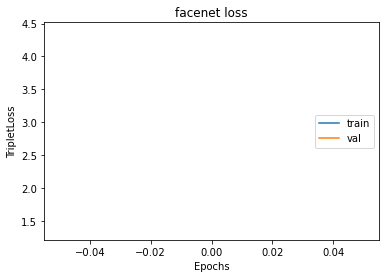


Epoch 2/100
----------


557it [01:48,  5.11it/s]
39it [00:02, 17.56it/s]

In [ ]:
from tqdm import tqdm 
from matplotlib import pyplot as plt
from IPython.display import clear_output

train_loss_history = []
val_loss_history = []
for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)
    loss = 0
    train_loss = pass_epoch(train_loader, 'Train')  
    val_loss = pass_epoch(val_loader, 'Eval')  
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    update_loss_hist(train_loss_history, val_loss_history, False)
    save_checkpoint({
        'epoch': epoch + 1,
        'arch': 'facenet',
        'state_dict': resnet.state_dict(),
        'optimizer' : optimizer.state_dict(),
    }, is_best=False, filename='./model_facenet/checkpoint_{:04d}.pth.tar'.format(epoch + 1))
update_loss_hist(train_loss_history, val_loss_history, True)